In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Loading the datasets
client_path = "client.csv"
invoice_path = "invoice.csv"

client_df = pd.read_csv(client_path)
invoice_df = pd.read_csv(invoice_path)

# Data preprocessing and aggregation workflow
Since we're planning to prepare data for a long-short term memory (LSTM) fraud detection model, transactions from `"invoice.csv"` will be grouped by client and month to form a time series. The goal will be to create a singular record per client per month with the relevant aggregated statistics.


The steps to do so are as follows:

1. Obtaining an overview of the data
2. Converting dates to datetime format - as the `date` columns are inconsistent
3. Aggregate monthly consumption and features - for each client, compute as follows:
  *   Consumption patterns
  *   Counter behaviour
  *   Temporal patterns
4. Undersampling non-fradulent data
5. Preparing data for LSTM




# Obtaining an overview of the data

Here, the `.info()` method will be used to ascertain if there are any missing datapoints.

In [ ]:
# Displaying basic info of client_df
print(f"Length of client_df: {len(client_df)} \n")
client_df.info()

Length of client_df: 11741 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11741 entries, 0 to 11740
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   region  11741 non-null  int64 
 1   date    11741 non-null  object
 2   dis     11741 non-null  int64 
 3   id      11741 non-null  int64 
 4   catg    11741 non-null  int64 
 5   target  11741 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 550.5+ KB


From the above summary, there are no missing datapoints, nor any null datapoints for `client_df`.

In [ ]:
# Displaying basic info of invoice_df
print(f"Length of invoice_df: {len(invoice_df)} \n")
invoice_df.info()

Length of invoice_df: 194374 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194374 entries, 0 to 194373
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    194374 non-null  int64 
 1   date                  194374 non-null  object
 2   tarif_type            194374 non-null  int64 
 3   counter_statue        194374 non-null  int64 
 4   reading_remarque      194374 non-null  int64 
 5   consommation_level_4  194374 non-null  int64 
 6   months_number         194374 non-null  int64 
 7   counter_type          194374 non-null  object
 8   counter_coefficient   194374 non-null  int64 
 9   consommation_level_1  194374 non-null  int64 
 10  consommation_level_2  194374 non-null  int64 
 11  consommation_level_3  194374 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 17.8+ MB


Similarly, the above summary reveals no missing datapoints, nor any null datapoints for `invoice_df`.

# Converting dates to datetime format

The rationale for doing this conversion is to ensure the consistency of all dates under the `dates` column.

In [ ]:
# Converting dates to datetime format
invoice_df["date"] = pd.to_datetime(invoice_df["date"], errors = "coerce", dayfirst = True)
invoice_df["year_month"] = invoice_df["date"].dt.to_period("M")

# Aggregating monthly consumption and features

The following will be computed for each client and month:

1.   Consumption-based features

  *   total_consumption - Total energy usage
  *   avg_monthly_consumption - Average energy usage per month
  *   consumption_std - Standard deviation (volatility) in energy consumption
  *   consumption_change_rate - Rate of change in usage

2.   Invoice and time patterns

  *   months_since_last_invoice - Difference between invoice dates to capture gaps
  *   monthly_invoice_count - Number of invoices issued that month

3.   Fraud indicator

  *   target - Fraud label from `client.csv`

In [ ]:
# Computing total consumption per invoice
invoice_df["total consumption"] = (
    invoice_df["consommation_level_1"] +
    invoice_df["consommation_level_2"] +
    invoice_df["consommation_level_3"] +
    invoice_df["consommation_level_4"]
)

# Sorting data for lag-based calculations
invoice_df = invoice_df.sort_values(by = ["id", "date"])

# Computing consumption change rate
invoice_df["previous consumption"] = invoice_df.groupby("id")["total consumption"].shift(1)
invoice_df["consumption_change_rate"] = (
    (invoice_df["total consumption"] - invoice_df["previous consumption"]) /
    invoice_df["previous consumption"]
)

# Handling NaN values in consumption_change_rate if previous_consumption is 0 or missing
invoice_df.loc[
    invoice_df["previous consumption"].isna() | (invoice_df["previous consumption"] == 0),
    "consumption_change_rate"
] = 0

# Computing months since last invoice
invoice_df["previous_invoice_date"] = invoice_df.groupby("id")["date"].shift(1)
invoice_df["months_since_last_invoice"] = (invoice_df["date"] - invoice_df["previous_invoice_date"]).dt.days // 30

# Grouping by client and month for feature aggregation
aggregated_invoice = invoice_df.groupby(["id", "year_month"]).agg(
    total_consumption = ("total consumption", "sum"),
    avg_monthly_consumption = ("total consumption", "mean"),
    consumption_std = ("total consumption", "std"),
    consumption_change_rate = ("consumption_change_rate", "mean"),
    months_since_last_invoice = ("months_since_last_invoice", "mean"),
    monthly_invoice_count = ("id", "count"),
).reset_index()

# Merging fraud labels from client_df
aggregated_invoice = aggregated_invoice.merge(client_df[["id", "target"]], on = "id", how = "left")


print(aggregated_invoice.head())

   id year_month  total_consumption  avg_monthly_consumption  consumption_std  \
0  10    2006-06                931                    931.0              NaN   
1  10    2007-06               1355                   1355.0              NaN   
2  10    2007-10                476                    476.0              NaN   
3  10    2008-02                761                    761.0              NaN   
4  10    2008-06                475                    475.0              NaN   

   consumption_change_rate  months_since_last_invoice  monthly_invoice_count  \
0                 0.000000                        NaN                      1   
1                 0.455424                       12.0                      1   
2                -0.648708                        4.0                      1   
3                 0.598739                        4.0                      1   
4                -0.375821                        4.0                      1   

   target  
0       0  
1       

To handle the `NaN` values arising from only one data sample in a month and the inability to calculate `consumption_change_rate` and `months_since_last_invoice` for the first row of data, we will change these values to 0.

In [ ]:
# For clients with only one invoice per month
aggregated_invoice["consumption_std"] = aggregated_invoice.apply(
    lambda row: 0 if row["monthly_invoice_count"] == 1 else row["consumption_std"],
    axis = 1
)

# Filling initial values for first row of consumption change and months since last invoice
aggregated_invoice["months_since_last_invoice"] = aggregated_invoice["months_since_last_invoice"].fillna(0)


print(aggregated_invoice.head())

   id year_month  total_consumption  avg_monthly_consumption  consumption_std  \
0  10    2006-06                931                    931.0              0.0   
1  10    2007-06               1355                   1355.0              0.0   
2  10    2007-10                476                    476.0              0.0   
3  10    2008-02                761                    761.0              0.0   
4  10    2008-06                475                    475.0              0.0   

   consumption_change_rate  months_since_last_invoice  monthly_invoice_count  \
0                 0.000000                        0.0                      1   
1                 0.455424                       12.0                      1   
2                -0.648708                        4.0                      1   
3                 0.598739                        4.0                      1   
4                -0.375821                        4.0                      1   

   target  
0       0  
1       

To prepare for LSTM input, the data must be sorted by client (`id`) and time (`year_month`).

In [ ]:
# Sorting by client and time
aggregated_invoice = aggregated_invoice.sort_values(by = ["id", "year_month"])


# Display final processed data
print(aggregated_invoice.head())

   id year_month  total_consumption  avg_monthly_consumption  consumption_std  \
0  10    2006-06                931                    931.0              0.0   
1  10    2007-06               1355                   1355.0              0.0   
2  10    2007-10                476                    476.0              0.0   
3  10    2008-02                761                    761.0              0.0   
4  10    2008-06                475                    475.0              0.0   

   consumption_change_rate  months_since_last_invoice  monthly_invoice_count  \
0                 0.000000                        0.0                      1   
1                 0.455424                       12.0                      1   
2                -0.648708                        4.0                      1   
3                 0.598739                        4.0                      1   
4                -0.375821                        4.0                      1   

   target  
0       0  
1       

In [ ]:
# Saving file into a new dataset
aggregated_invoice.to_csv("aggregated_datasetV2.csv", index = False)
print("Dataset saved!")

Dataset saved!


# Imbalance Visualisation
By separating and counting the values of fraud and non-fraud cases, it's clear to see that there is a heavy imabalance between the two classes. This suggests that measures will need to be taken to counter this.

<ipython-input-13-ec1eca881209>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=aggregated_invoice, palette="viridis")


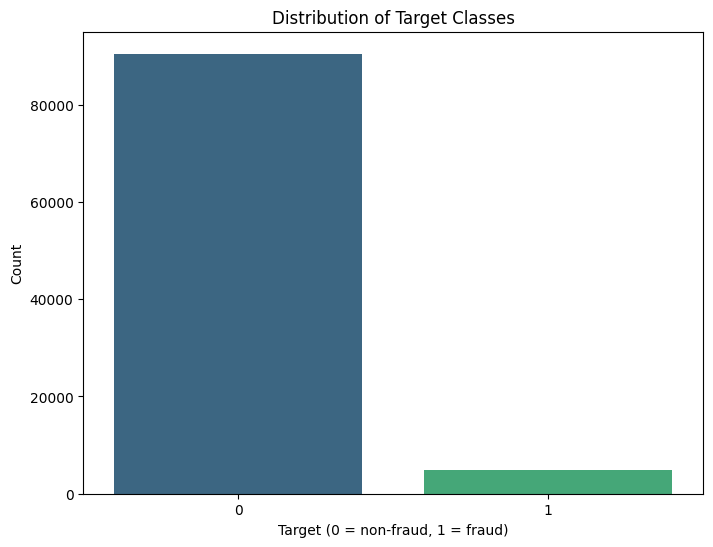

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x="target", data=aggregated_invoice, palette="viridis")
plt.title("Distribution of Target Classes")
plt.xlabel("Target (0 = non-fraud, 1 = fraud)")
plt.ylabel("Count")
plt.show()

# Dataset correlation heatmap

A correlation heatmap was generated for the saved dataset to display the correlation between features. This was done after training and testing the LSTM model, in an effort to ascertain the reason of the low precision of both models.

In [ ]:
# Loading aggregated dataset
aggregated_invoice = pd.read_csv("aggregated_datasetV2.csv")
aggregated_invoice.columns

Index(['id', 'year_month', 'total_consumption', 'avg_monthly_consumption',
       'consumption_std', 'consumption_change_rate',
       'months_since_last_invoice', 'monthly_invoice_count', 'target'],
      dtype='object')

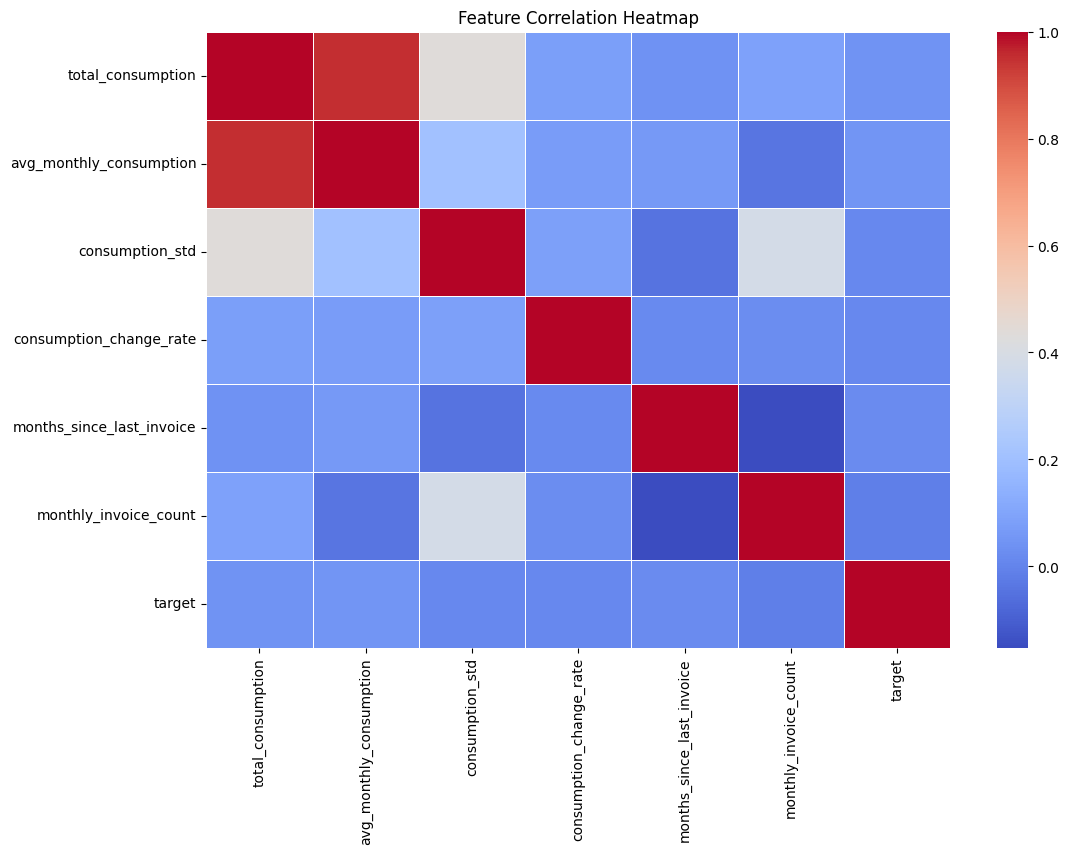

In [ ]:
# Compute correlation matrix
numeric_invoice = aggregated_invoice.drop(columns =['year_month', 'id'])
corr_matrix = numeric_invoice.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

As seen from the above, there is weak correlation between the target category and all other categories (besides itself). Hence, this may be why the model struggles to classify fraud, explaining the low precision.